In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# Paths
dataset_dir   = '/home/dl/Downloads/TEST/Dataset1/train_images'
CSV_PATH      = '/home/dl/Downloads/TEST/Dataset1/train.csv'
test_dir      = '/home/dl/Downloads/TEST/Dataset1/test_images'
TEST_CSV_PATH = '/home/dl/Downloads/TEST/Dataset1/test.csv'

# Constants
IMG_SIZE = 300
BATCH_SIZE = 16
EPOCHS = 20
NUM_CLASSES = 5
seed = 42

# Set seeds
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

2025-05-08 12:11:12.884058: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746686472.898128  740787 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746686472.902225  740787 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746686472.914018  740787 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746686472.914034  740787 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746686472.914036  740787 computation_placer.cc:177] computation placer alr

In [ ]:
# Load train dataframe
df = pd.read_csv(CSV_PATH)
df['image_path'] = df['id_code'].apply(lambda x: os.path.join(dataset_dir, f"{x}.png"))
df.rename(columns={'diagnosis': 'label'}, inplace=True)

# Load test dataframe
test_df = pd.read_csv(TEST_CSV_PATH)
test_df['image_path'] = test_df['id_code'].apply(lambda x: os.path.join(test_dir, f"{x}.png"))

# Train-validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=seed
)

In [ ]:
# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['label']),
    y=train_df['label']
)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Augmentation
def augment_image(img):
    img_uint8 = (img * 255).astype(np.uint8)
    if np.random.rand() < 0.5:
        img_uint8 = cv2.flip(img_uint8, 1)
    if np.random.rand() < 0.3:
        img_uint8 = cv2.flip(img_uint8, 0)
    angle = np.random.uniform(-25, 25)
    scale = np.random.uniform(0.9, 1.1)
    h, w = img_uint8.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, scale)
    img_uint8 = cv2.warpAffine(img_uint8, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    brightness = np.random.randint(-30, 30)
    img_uint8 = cv2.add(img_uint8, brightness)
    contrast = np.random.uniform(0.8, 1.2)
    img_uint8 = cv2.convertScaleAbs(img_uint8, alpha=contrast)
    return img_uint8.astype('float32') / 255.0

In [ ]:
# Preprocessing
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load: {img_path}")
        img = np.zeros((512, 512, 3), dtype=np.uint8)
    green_channel = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green_channel)
    filtered = cv2.medianBlur(enhanced, 3)
    p2, p98 = np.percentile(filtered, (2, 98))
    stretched = np.clip((filtered - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)
    processed = cv2.merge([stretched, stretched, stretched])
    processed = cv2.resize(processed, (IMG_SIZE, IMG_SIZE))
    normalized = processed.astype('float32') / 255.0
    return normalized

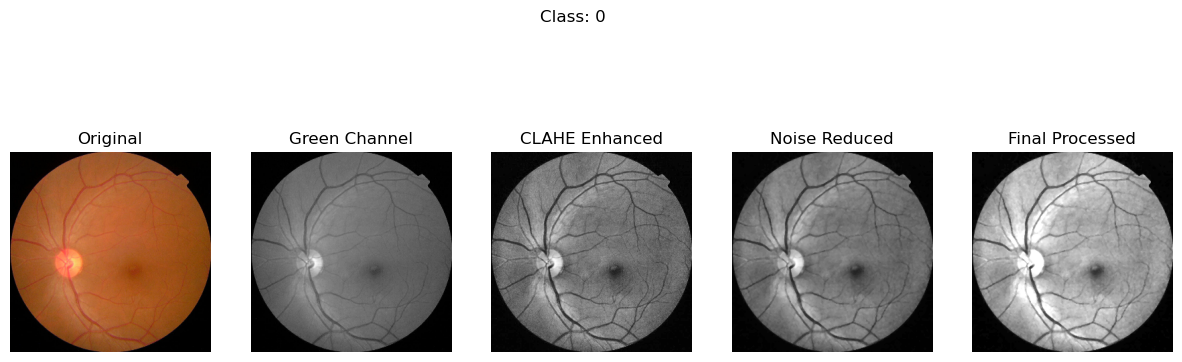

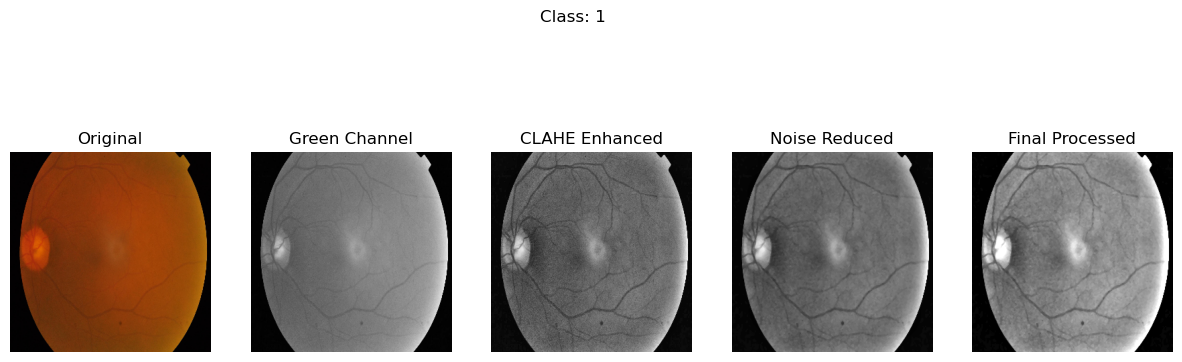

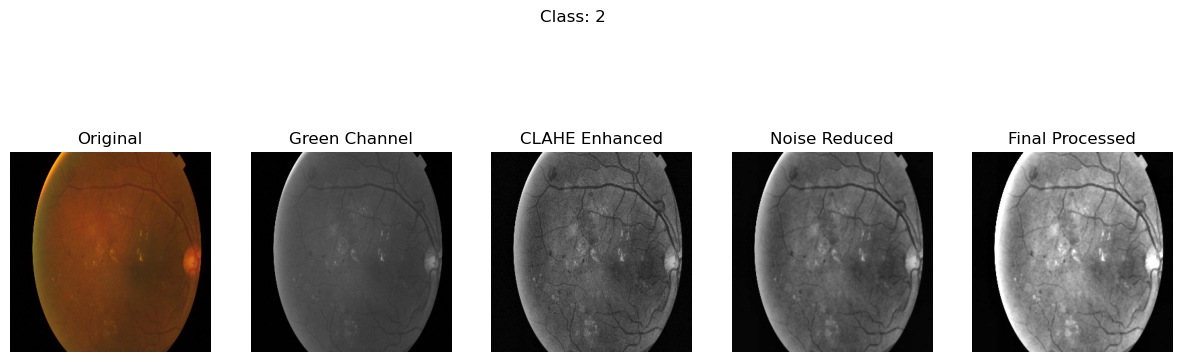

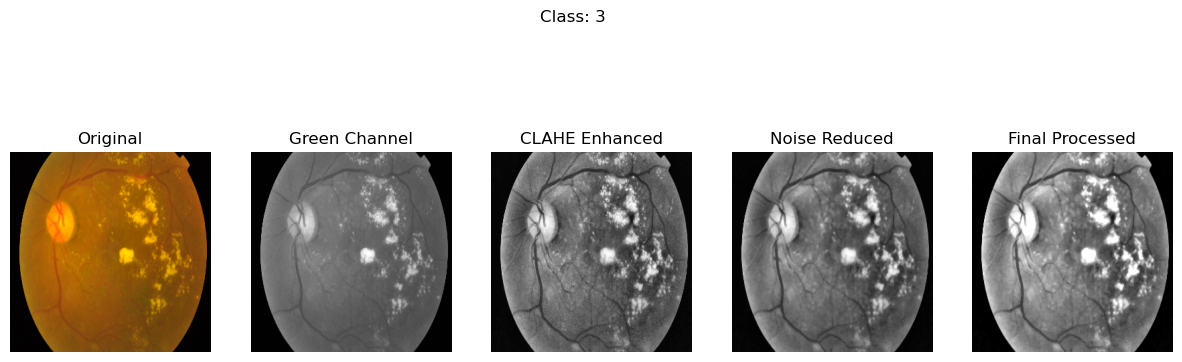

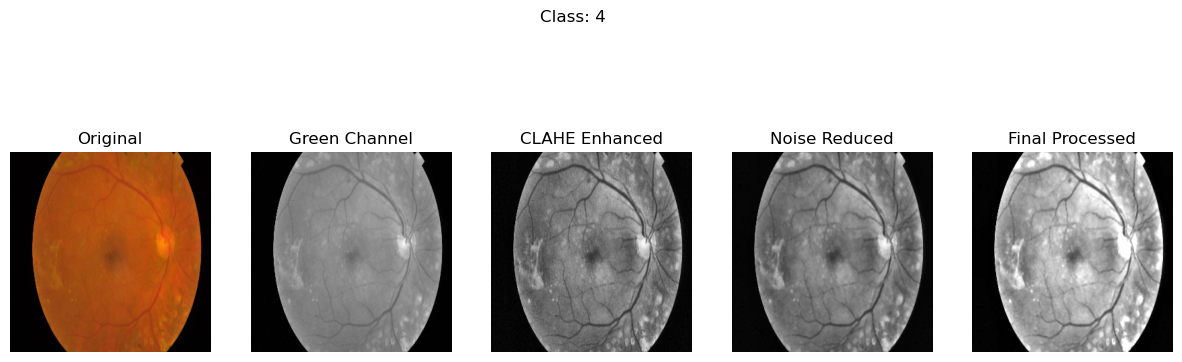

In [ ]:
# Visualize preprocessing steps
def visualize_preprocessing_steps(df):
    sampled_df = df.groupby('label').first().reset_index()
    for idx, row in sampled_df.iterrows():
        img_path = row['image_path']
        label = row['label']
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        orig_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        green_channel = orig_img[:, :, 1]
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(green_channel)
        filtered = cv2.medianBlur(enhanced, 3)
        p2, p98 = np.percentile(filtered, (2, 98))
        stretched = np.clip((filtered - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)
        processed = cv2.merge([stretched, stretched, stretched])
        processed = cv2.resize(processed, (IMG_SIZE, IMG_SIZE))
        normalized = processed.astype('float32') / 255.0

        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Class: {label}')
        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')
        plt.subplot(1, 5, 2)
        plt.imshow(green_channel, cmap='gray')
        plt.title('Green Channel')
        plt.axis('off')
        plt.subplot(1, 5, 3)
        plt.imshow(enhanced, cmap='gray')
        plt.title('CLAHE Enhanced')
        plt.axis('off')
        plt.subplot(1, 5, 4)
        plt.imshow(filtered, cmap='gray')
        plt.title('Noise Reduced')
        plt.axis('off')
        plt.subplot(1, 5, 5)
        plt.imshow(normalized)
        plt.title('Final Processed')
        plt.axis('off')
        plt.show()

# Call visualization before training
visualize_preprocessing_steps(df)

In [ ]:
# Generator
def generator(df, batch_size, is_train=True):
    while True:
        if is_train:
            df = df.sample(frac=1).reset_index(drop=True)
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            images = np.array([preprocess_image(x) for x in batch_df['image_path']])
            if is_train:
                images = np.array([augment_image(img) for img in images])
            labels = batch_df['label'].values
            one_hot_labels = to_categorical(labels, NUM_CLASSES)
            sample_weights = np.array([class_weights_dict[label] for label in labels])
            yield images, one_hot_labels, sample_weights

In [ ]:
# Model
base_model = EfficientNetB3(
    include_top=False,
    weights='imagenet',  # Use pre-trained ImageNet weights
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)
]

# Train
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE

history = model.fit(
    generator(train_df, BATCH_SIZE, is_train=True),
    steps_per_epoch=steps_per_epoch,
    validation_data=generator(val_df, BATCH_SIZE, is_train=False),
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20


/home/dl/.local/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1157']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)
I0000 00:00:1746686899.754643  741147 service.cc:152] XLA service 0x7210d4002e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746686899.754665  741147 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-05-08 12:18:20.850028: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746686905.814410  741147 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/183 ━━━━━━━━━━━━━━━━━━━━ 3:57:59 78s/step - accuracy: 0.5000 - loss: 2.6521

I0000 00:00:1746686940.343053  741147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4374 - loss: 1.4342

2025-05-08 12:23:38.501174: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3271', 76 bytes spill stores, 76 bytes spill loads

2025-05-08 12:23:38.870166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3271', 3816 bytes spill stores, 3796 bytes spill loads



183/183 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.4380 - loss: 1.4331 - val_accuracy: 0.4958 - val_loss: 1.8284 - learning_rate: 1.0000e-04
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.6989 - loss: 0.9487 - val_accuracy: 0.5014 - val_loss: 2.1995 - learning_rate: 1.0000e-04
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7467 - loss: 0.8551 - val_accuracy: 0.5069 - val_loss: 2.3275 - learning_rate: 1.0000e-04
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7526 - loss: 0.8324

2025-05-08 12:40:45.269382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3271', 132 bytes spill stores, 132 bytes spill loads

2025-05-08 12:40:45.706488: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3271', 4500 bytes spill stores, 4000 bytes spill loads



183/183 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7527 - loss: 0.8322 - val_accuracy: 0.6987 - val_loss: 1.3117 - learning_rate: 1.0000e-04
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.7756 - loss: 0.6989 - val_accuracy: 0.7319 - val_loss: 1.3054 - learning_rate: 1.0000e-04
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8258 - loss: 0.5948 - val_accuracy: 0.7266 - val_loss: 1.4332 - learning_rate: 1.0000e-04
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.8240 - loss: 0.5522 - val_accuracy: 0.5969 - val_loss: 1.5327 - learning_rate: 1.0000e-04
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8470 - loss: 0.5124
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
183/183 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8469 - loss: 0.5125 - val_accuracy: 0.3598 - val_loss: 1.6918 - learning_rate: 1.0000e-04
Epoch 9/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.8591 - l

In [ ]:
model.save('/home/dl/Downloads/TEST/model1/model1.keras')
model.save('/home/dl/Downloads/TEST/model1/model1.h5')
model.save_weights('/home/dl/Downloads/TEST/model1/model1.weights.h5')





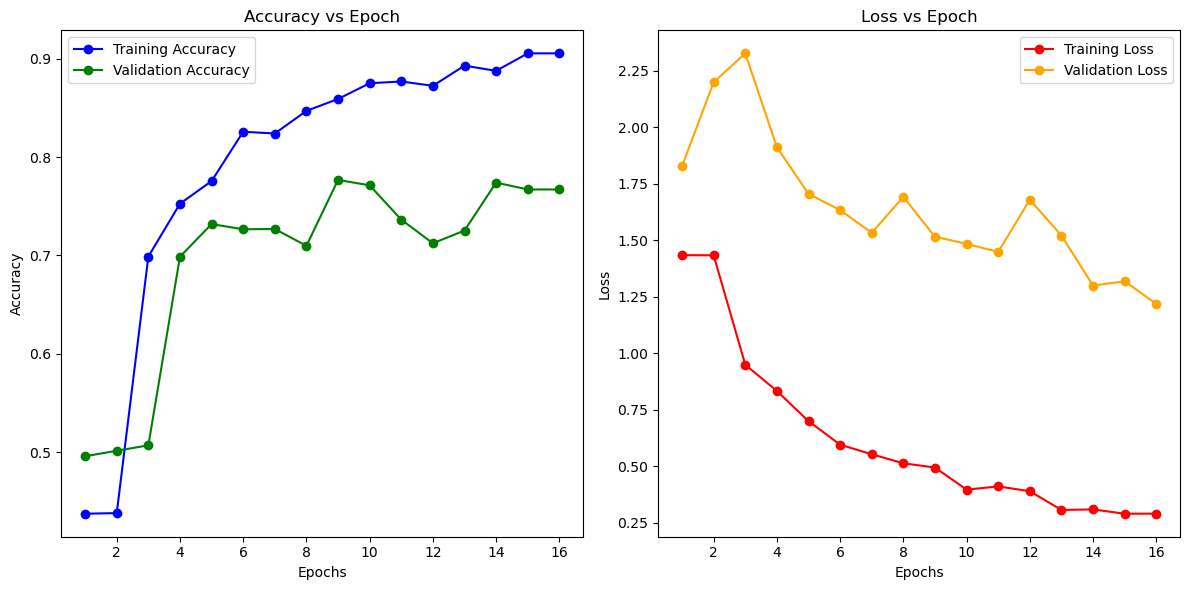

In [ ]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test set
print("Evaluating on test set...")
test_images = np.array([preprocess_image(x) for x in test_df['image_path']])
predictions = model.predict(test_images, batch_size=BATCH_SIZE)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion matrix if true labels are available
if 'diagnosis' in test_df.columns:
    true_labels = test_df['diagnosis'].values
    cm = confusion_matrix(true_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
else:
    print("Test CSV has no 'diagnosis' column to compute confusion matrix.")

# Prepare output DataFrame
# Extract filename only and remove ".png"
id_codes = test_df['image_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

output_df = pd.DataFrame({
    'id_code': id_codes,
    'diagnosis': predicted_classes
})

# Save to CSV
output_csv_path = '/home/dl/Downloads/TEST/output_model1.csv'
output_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")

# Print predictions
print("Predictions for test set:")
print(predicted_classes)

Evaluating on test set...
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Test CSV has no 'diagnosis' column to compute confusion matrix.
Predictions saved to /home/dl/Downloads/TEST/output_model1.csv
Predictions for test set:
[1 2 3 ... 3 3 0]


In [ ]:
from tqdm import tqdm  # Import tqdm at the top

# --- Point this to your unseen-test parent folder ---
UNSEEN_TEST_DIR = '/home/dl/Downloads/TEST/Dataset2'

# Human-readable labels
CLASS_NAMES = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']

# Gather all test images and their true labels
X_test, y_true = [], []
total_count = 0

print("\nStarting to load and preprocess images...\n")
for label_idx in range(5):              # folders named "0", "1", ..., "4"
    folder = os.path.join(UNSEEN_TEST_DIR, str(label_idx))
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"\nProcessing folder '{label_idx}' with {len(files)} images...")

    for fname in tqdm(files, desc=f"Class {label_idx}", unit="image"):
        img_path = os.path.join(folder, fname)
        X_test.append(preprocess_image(img_path))
        y_true.append(label_idx)
        total_count += 1

print(f"\nTotal images loaded: {total_count}")

X_test = np.stack(X_test, axis=0)
y_true = np.array(y_true)

print("\nStarting prediction...\n")
y_prob = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

# Compute and print accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
acc = accuracy_score(y_true, y_pred)
print(f"\nUnseen Test Accuracy: {acc*100:.2f}%")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix on Unseen Test Set')
plt.tight_layout()
plt.show()



Starting to load and preprocess images...


Processing folder '0' with 25810 images...


Class 0: 100%|██████████| 25810/25810 [03:14<00:00, 133.03image/s]



Processing folder '1' with 2443 images...


Class 1: 100%|██████████| 2443/2443 [00:18<00:00, 129.77image/s]



Processing folder '2' with 5292 images...


Class 2: 100%|██████████| 5292/5292 [00:40<00:00, 130.98image/s]



Processing folder '3' with 873 images...


Class 3: 100%|██████████| 873/873 [00:06<00:00, 133.95image/s]



Processing folder '4' with 708 images...


Class 4: 100%|██████████| 708/708 [00:05<00:00, 135.89image/s]



Total images loaded: 35126

Starting prediction...



2025-05-08 14:41:52.987303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746695513.072065  752767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746695513.097018  752767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746695513.286323  752767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746695513.286335  752767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746695513.286337  752767 computation_placer.cc:177] computation placer alr

Loading and preprocessing test images:


Class 4: 100%|██████████| 708/708 [00:05<00:00, 130.29img/s]



Total images loaded: 35126

Predicting on test set:


Batches:   0%|          | 0/2196 [00:00<?, ?batch/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1746695802.923222  752949 service.cc:152] XLA service 0x7b1944001530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746695802.923260  752949 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-05-08 14:46:43.055081: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746695803.780113  752949 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-05-08 14:46:44.562838: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3221', 76 bytes spill stores, 76 bytes spill loads

2025-05-08 14:46:44.875946: I external/local_xla/xla/stream_e


Unseen Test Accuracy: 81.6%


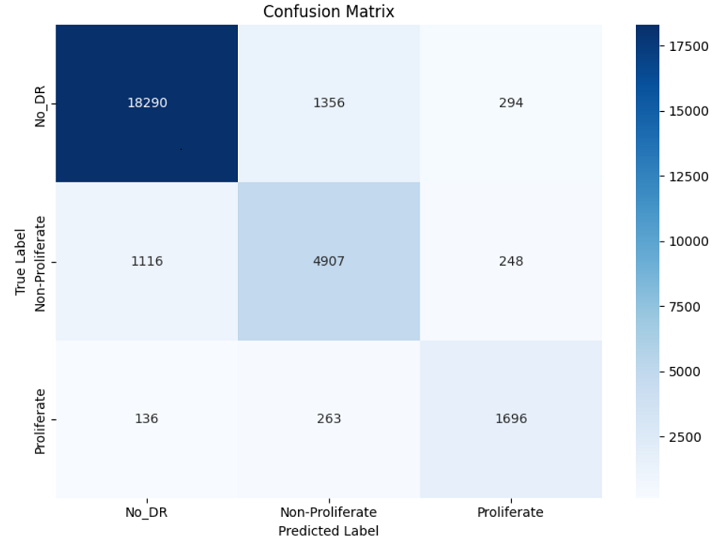

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# === SETTINGS ===
MODEL_PATH      = '/home/dl/Downloads/TEST/model1/model1.h5'
UNSEEN_TEST_DIR = '/home/dl/Downloads/TEST/Dataset2'
IMG_SIZE        = 300
BATCH_SIZE      = 16
CLASS_NAMES     = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate']



#Converting these into three classes
#No_DR -> No_DR
#Mild, Moderate, Severe -> Proliferate
#Proliferate -> Proliferate
CLASS_NAMES = ['No_DR', 'Non - Proliferate', 'Proliferate']


# === Load model ===
model = load_model(MODEL_PATH, compile=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# === Preprocessing (same as training) ===
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        img = np.zeros((512, 512, 3), dtype=np.uint8)
    green = img[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green)
    filtered = cv2.medianBlur(enhanced, 3)
    p2, p98 = np.percentile(filtered, (2, 98))
    stretched = np.clip((filtered - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)
    merged = cv2.merge([stretched, stretched, stretched])
    resized = cv2.resize(merged, (IMG_SIZE, IMG_SIZE))
    return resized.astype('float32') / 255.0

# === Gather and preprocess test data with tqdm ===
X_test, y_true = [], []
print("Loading and preprocessing test images:")
for label_idx in range(len(CLASS_NAMES)):      # 0..4
    folder = os.path.join(UNSEEN_TEST_DIR, str(label_idx))
    if not os.path.isdir(folder):
        continue
    files = [f for f in os.listdir(folder) if f.lower().endswith('.jpeg')]
    for fname in tqdm(files, desc=f"Class {label_idx}", unit="img"):
        img_path = os.path.join(folder, fname)
        X_test.append(preprocess_image(img_path))
        y_true.append(label_idx)

X_test = np.stack(X_test, axis=0)
y_true = np.array(y_true)
print(f"\nTotal images loaded: {len(X_test)}\n")

# === Predict with tqdm ===
print("Predicting on test set:")
y_pred = []
for i in tqdm(range(0, len(X_test), BATCH_SIZE), desc="Batches", unit="batch"):
    batch = X_test[i:i + BATCH_SIZE]
    probs = model.predict(batch, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
y_pred = np.array(y_pred)

# === Metrics ===
acc = accuracy_score(y_true, y_pred)
print(f"\nUnseen Test Accuracy: {acc * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix on Unseen Test Set')
plt.tight_layout()
plt.show()
